# Question 1
## Part 1.1 Implement an agent-based model 

You can use the following template or feel free to implement your own program. Please refer to the handout for details about parameters settings. 

In [195]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

#### Define Agent class

In [196]:
class Agent:
    '''
    Allowable statuses: (R) Recovered
                        (S) Susceptible to Infection
                        (I) Infected
                        (Q) Quarantined
                        
    Asymptomatic:  True if agent is asymptomatic when infected
    Distancing: True if agent is physically distancing
    Mask: True if agent is wearing a mask
    '''
    statuses = ['R', 'S', 'I', 'Q'] # allowable statuses
    days_infected = 0    # How long agent has been infected, if currently infected
    
    def __init__(self, 
                 position, 
                 status,  
                 mask, 
                 distancing):
        '''
        Initialize an agent.
        '''
        # position (x,y)
        self.position = position

        # status
        if status in self.statuses:
            self.status = status
        else:
            raise ValueError('status: ' + status + ' is not valid.')

        # possibly asymptomatic if infected
        if status == 'I':
            if self.is_asymptomatic():
                 self.asymptomatic = True
            else:
                self.asymptomatic = False
        else:
            self.asymptomatic = False 
                            
        self.mask = mask
        self.distancing = distancing 
        
    
    def is_event(self, num_event, num_outcomes):
        '''
        If an event has a 25% chance, num_event = 1 and num_outcomes = 4
        Returns true if event is selected from outcomes, False otherwise.
        '''
        return random.randint(1,num_outcomes) <= num_event
    
    
    def is_infected(self, adjacent_agents):
        '''
        Returns True if the agent is now infected, given whether
        an adjacent agent is infected or masked and whether the 
        agent is masked. False otherwise.
        
        Check is performed for each agent adjacent to this agent. 
        ''' 
        infected = False
        
        # perform check for all adjacent agents
        for adjacent in adjacent_agents:
        
            # chance of infection if an adjacent agent is infected
            if adjacent.status == 'I':

                # infection probability depends on mask status of both
                if self.mask and adjacent.mask: 

                    if self.is_event(1,10000): # 0.01% chance
                        infected = True

                elif self.mask or adjacent.mask: 

                    if self.is_event(1,100):  # 1% chance
                        infected = True

                else:  

                    if self.is_event(1,4):   # 25% chance
                        infected = True
            
        return infected
            
    
    def is_asymptomatic(self):
        '''
        Returns True if agent is asymptomatic, False otherwise.
        '''
        return self.is_event(1,5) # 20% chance of being asymptomatic
        
    
    def will_quarantine(self):
        '''       
        Returns True if the agent has been infected for 
        at least 3 days and is symptomatic, False otherwise.
        '''       
        return self.days_infected > 2 and not self.asymptomatic

        
    
    def infection_over(self):
        '''
        Returns True if the agent has been infected for at
        least 15 days, False otherwise
        '''
        return self.days_infected > 14
                
    
    def update_status(self, adjacent_agents):
        '''
        Checks whether modification to the agent's status 
        is needed, and updates the status as necessary.
        '''
        
        if self.status == 'S': # not yet infected
            
            if self.is_infected(adjacent_agents):
                self.status = 'I'
                
        elif self.status == 'I': # already infected
            
            if self.will_quarantine():
                self.status = 'Q'
        
            if self.infection_over():
                self.status = 'R'
                
        elif self.status == 'Q': # already in quarantine
            
            if self.infection_over():
                self.status = 'R'
            
            
    def update_agent(self, new_position, adjacent_agents):
        '''
        Updates all agent fields based on given position and 
        adjacent agents.
        '''
        
        # update position
        self.position = new_position
        
        # update days infected if already infected
        if self.status == 'I' or self.status == 'Q':
            self.days_infected += 1 # day passed since infection started            
        
        # update status
        status_before = self.status
        self.update_status(adjacent_agents)
        
         # if now infected, determine if asymptomatic
        if status_before != 'I' and self.status == 'I':
            self.asymptomatic = self.is_asymptomatic()
            
        elif status_before != 'R' and self.status == 'R':
            
            # reset metrics related to infection
            self.days_infected = 0
            self.asymptomatic = False
            
    
    def __str__(self):  
        return  'Agent{'+'position:'+ str(self.position)+', status:'+ str(self.status)+', mask:'+ str(self.mask)+', distancing:'+ str(self.distancing)+', days_infected:'+ str(self.days_infected)+', asymptomatic:'+ str(self.asymptomatic)+'}'      
    
    
    def has_died(self):
        '''
        Return True if agent dies due to infection, False otherwise.
        '''  
        return self.status == 'I' and self.is_event(2,1000) #0.2% chance
    

#### Test Agent class

In [197]:
print("Test constructor")
a1 = Agent((1,1), 'I', mask=True, distancing=True)
print(a1)

# check provided parameters
assert a1.position == (1,1)
assert a1.status == 'I'
assert a1.mask == True
assert a1.distancing == True
assert a1.days_infected == 0


# check derived parameters
num = 100000
counter = 0
for i in range(num):
    a1 = Agent((1,1), 'I', mask=True, distancing=True)
    if a1.asymptomatic == True:
        counter += 1
assert round(counter/num,2) == 0.20

Test constructor
Agent{position:(1, 1), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:True}


In [198]:
print('Test is_event()')
a1 = Agent((1,1), 'I', mask=True, distancing=True)

num = 100000
counter = 0
for i in range(num):
    if a1.is_event(1,10000):
        counter += 1
assert round(counter/num,4) == 0.0001, 'Failed with ' + str(round(counter/num,4))

counter = 0
for i in range(num):
    if a1.is_event(1,100):
        counter += 1
assert round(counter/num,2) == 0.01

counter = 0
for i in range(num):
    if a1.is_event(1,4):
        counter += 1
assert round(counter/num,2) == 0.25

counter = 0
for i in range(num):
    if a1.is_event(2,1000):
        counter += 1
assert round(counter/num,3) == 0.002, 'Failed with ' + str(round(counter/num,3))

Test is_event()


In [199]:
print('Test is_asymptomatic()')

counter = 0
for i in range(num):
    if a1.is_asymptomatic():
        counter += 1
assert round(counter/num,2) == 0.20

Test is_asymptomatic()


In [200]:
print('Test will_quarantine()')

a2 = Agent((0,1), 'I', mask=True, distancing=True)

# possibility of quarantine when symptomatic
a2.asymptomatic = False

a2.days_infected = 2
assert a2.will_quarantine() == False

a2.days_infected = 3
assert a2.will_quarantine() == True

a2.days_infected = 4
assert a2.will_quarantine() == True


# when asymptomatic, will not quarantine
a2.asymptomatic = True
a2.days_infected = 2
assert a2.will_quarantine() == False

a2.days_infected = 3
assert a2.will_quarantine() == False

a2.days_infected = 4
assert a2.will_quarantine() == False


Test will_quarantine()


In [201]:
print('Test infection_over()')
a3 = Agent((0,1), 'I', mask=True, distancing=True)
a3.days_infected = 13
assert a3.infection_over() == False

a3.days_infected = 14
assert a3.infection_over() == False

a3.days_infected = 15
assert a3.infection_over() == True


Test infection_over()


In [202]:
print('Test is_infected()')
a1 = Agent((1,1), 'S', mask=True, distancing=True)
a2 = Agent((0,1), 'I', mask=True, distancing=True)

# test 1 adjacent, 1 infected, both masked
a1.mask = True
a2.mask = True
num = 100000
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,4) == 0.0001

# test 1 adjacent, 1 infected, only agent masked
a1.mask = True
a2.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 1 adjacent, 1 infected, only adjacent masked
a1.mask = False
a2.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 1 adjacent, 1 infected, no masks
a1.mask = False
a2.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.25

Test is_infected()


In [203]:
print('Test is_infected()')
a3 = Agent((1,2), 'R', mask=True, distancing=True)

# test 2 adjacent, 1 infected, all masked
a1.mask = True
a2.mask = True
a3.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,4) == 0.0001

# test 2 adjacent, 1 infected, only agent masked
a1.mask = True
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 2 adjacent, 1 infected, no one masked
a2.mask = False
a3.mask = False
a1.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,2) == 0.25

Test is_infected()


In [204]:
print('Test is_infected()')
# test 2 adjacent, 2 infected, all masked
a3.status = 'I'
a1.mask = True
a2.mask = True
a3.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,4))
assert round(counter/num,4) > 0.0001, 'Failed with ' + str(round(counter/num,4))

# test 2 adjacent, 2 infected, agent masked
a3.status = 'I'
a1.mask = True
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) > 0.01

# test 2 adjacent, 2 infected, agent masked, one adjacent masked
a3.status = 'I'
a1.mask = True
a2.mask = True
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) >= 0.01

# test 2 adjacent, 2 infected, no one masked
a3.status = 'I'
a1.mask = False
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) > 0.25

Test is_infected()
0.0003
0.02
0.01
0.44


In [205]:
print('Test update_status()')
a1 = Agent((1,1), 'R', mask=True, distancing=True)
a2 = Agent((0,1), 'I', mask=False, distancing=True)

# test R status
print('Test R status...')
a1.update_status([a2])
assert a1.status == 'R'

# test I status
print('Test I status...')

a1.status = 'I'
a1.days_infected = 0 # test not yet quarantined
a1.asymptomatic = True
a1.update_status([a2])  
assert a1.status == 'I'


a1.status = 'I'
a1.days_infected = 3 # test change to quarantined
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'Q'

a1.status = 'I'
a1.days_infected = 15 # test change to recovered
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'R'

# test Q status
print('Test Q status...')
a1.status = 'Q'
a1.days_infected = 15 # test change to recovered
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'R'

# test S status
print('Test S status...')
a1.status = 'S'
a1.days_infected = 0
a1.asymptomatic = False
num = 10000
counter = 0
for i in range(num):
    a1.status = 'S'
    a1.update_status([a2])
    if a1.status == 'I':
        counter += 1
assert round(counter/num,2) == 0.01

Test update_status()
Test R status...
Test I status...
Test Q status...
Test S status...


In [206]:
print('Test update_agent()')

a1 = Agent((1,1), 'R', mask=False, distancing=True)
a2 = Agent((0,1), 'I', mask=False, distancing=True)
a1.update_agent((2,2), [a2])

# check position
assert a1.position == (2,2)

# check days_infected
a1.status = 'I'
a1.update_agent((2,2), [a2])
assert a1.days_infected == 1

# check status if now recovered
# check metrics if now recovered
a1.status = 'I'
a1.days_infected = 14
a1.update_agent((2,2), [a2])
assert a1.status == 'R'
assert a1.days_infected == 0
assert a1.asymptomatic == False

# check status if now recovered
# check metrics if now recovered
a1.status = 'Q'
a1.days_infected = 14
a1.update_agent((2,2), [a2])
assert a1.status == 'R'
assert a1.days_infected == 0
assert a1.asymptomatic == False
    

# check asymptomatic if now infected
a1.status = 'S'
a1.days_infected = 0
a1.asymptomatic = False
a1.update_agent((2,2), [a2])

num = 100000
counter = 0
for i in range(num):
    a1.status = 'S'
    a1.asymptomatic = False
    a1.update_agent((2,2), [a2])
    if a1.asymptomatic == True:
        counter += 1
assert round(counter/num,2) == 0.05

Test update_agent()


In [207]:
print('Test has_died()')
num = 100000

# check for infected status
a2 = Agent((0,1), 'I', mask=False, distancing=True)
counter = 0
for i in range(num):
    if a2.has_died():
        counter += 1
assert round(counter/num,3) == 0.002


# check if status not infected
a3 = Agent((0,1), 'S', mask=False, distancing=True)
counter = 0
for i in range(num):
    if a3.has_died():
        counter += 1
assert round(counter/num,1) == 0.0

Test has_died()


In [208]:
print('All tests pass for Agent class.')

All tests pass for Agent class.


#### Define AgentGenerator class

In [209]:
class AgentGenerator:
    
    def __init__(self, m, num_infected, percent_distancing, percent_mask, percent_vaccinated = 0.0):
        '''
        Initialize the world and agents in the world. 

        Parameters:
        n: size of the world
        m: number of agents 
        '''        
        # capture parameters
        self.m = m
        self.num_infected = num_infected

        # set discrete numbers for distancing, mask, vaccinated
        self.num_distancing = int(round(percent_distancing*m))
        self.num_mask = int(round(percent_mask*m))
        self.num_vaccinated = int(round(percent_vaccinated*m))
        
        # validation checks        
        if self.num_infected + self.num_vaccinated > m:
            raise ValueError('not allowed to have (infected + vaccinated) > total number of agents')
    
    
    def is_infected(self, current_infected):
        '''
        Returns True if there should be more infected agents 
        (i.e. this agent is selected as infected). Returns False otherwise.
        '''
        return current_infected < self.num_infected
    
    
    def is_vaccinated(self,infected,current_vaccinated):
        '''
        Returns True if the agent is not infected and there should be more vaccinated agents 
        (i.e. this agent is selected as vaccinated). 
        Returns False otherwise.
        '''
        if infected:
            return False # can't be both infected and vaccinated
        else: 
            return current_vaccinated < self.num_vaccinated
    
    
    def get_status(self, infected, vaccinated):
        
        status = 'S'
        if infected:
            status = 'I'
        elif vaccinated:
            status = 'R'
        
        return status
    

    def select_indexes(self, num_positions):
    
        chosen = list()
        for i in range(num_positions):
            
            position = random.randint(0,self.m-1)
            while position in chosen:
                
                # try again
                position = random.randint(0,self.m-1)
            
            chosen.append(position)
        return chosen


    def generate_agents(self):
        '''
        Creates and returns a list of m agents, each created with 
        a randomly chosen position from the n x n grid, with the 
        required number of agents selected as infected and vaccinated.
        
        After setting status, randomly selects agents to be masked.
        Separately from mask, randomly selects agents to be distancing.
        '''
        
        # create agents
        agents = list()
        
        # set counters
        current_infected = 0
        current_vaccinated = 0
        
        # randomly select indexes for mask and distancing
        mask_indexes = self.select_indexes(self.num_mask)
        distancing_indexes =  self.select_indexes(self.num_distancing)
        
        for i in range(self.m):
        
            # select if agent is infected
            infected = self.is_infected(current_infected)
            if infected:
                current_infected += 1
            
            # select if agent is vaccinated
            vaccinated = self.is_vaccinated(infected, current_vaccinated)
            if vaccinated:
                current_vaccinated += 1
                
            # set status
            status = self.get_status(infected, vaccinated)

            # set values for mask and distancing
            mask = i in mask_indexes
            distancing = i in distancing_indexes
                
            # position will be set later
            new_agent = Agent((-1,-1), status, mask=mask, distancing=distancing)
            agents.append(new_agent)          
        
        return agents
    

#### Testing AgentGenerator class

In [210]:
print('Test constructor')

# test version with defined percent_vaccinated
ag = AgentGenerator(100,10,0.25,0.35,0.45)
assert ag.m == 100
assert ag.num_infected == 10
assert ag.num_distancing == 25
assert ag.num_mask == 35
assert ag.num_vaccinated == 45

# test version without defined percent_vaccinated
ag = AgentGenerator(100,10,0.25,0.35)
assert ag.m == 100
assert ag.num_infected == 10
assert ag.num_distancing == 25
assert ag.num_mask == 35
assert ag.num_vaccinated == 0

Test constructor


In [211]:
print('Test is_infected()')

ag = AgentGenerator(100,1,0.25,0.35,0.45)
current_infected = 0
infected = ag.is_infected(current_infected)
assert infected == True

current_infected = 1
infected = ag.is_infected(current_infected)
assert infected == False

Test is_infected()


In [212]:
print('Test is_vaccinated()')

ag = AgentGenerator(100,1,0.25,0.35,0.45)

# infected should not become vaccinated
current_vaccinated = 0
infected = True
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == False


# remaining should become vaccinated
current_vaccinated = 0
infected = False
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == True

# full should not become vaccinated
current_vaccinated = 45
infected = False
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == False



Test is_vaccinated()


In [213]:
print('Test get_status()')
ag = AgentGenerator(100,1,0.25,0.35,0.45)

# infected
infected = True
vaccinated = False
status = ag.get_status(infected, vaccinated)
assert status == 'I'

# vaccinated
infected = False
vaccinated = True
status = ag.get_status(infected, vaccinated)
assert status == 'R'

# susceptible
infected = False
vaccinated = False
status = ag.get_status(infected, vaccinated)
assert status == 'S'


Test get_status()


In [214]:
print('Test select_indexes()')

m = 100
ag = AgentGenerator(m,1,0.25,0.35,0.45)

num_positions = 25
positions = ag.select_indexes(num_positions)

assert len(positions) == num_positions
assert len(set(positions)) == num_positions

counter = 0
for p in positions:
    if p >= m or p < 0: # should be within [0...m-1] index positions
        counter += 1
assert counter == 0
print(positions)

Test select_indexes()
[99, 9, 22, 73, 68, 38, 20, 62, 82, 81, 61, 52, 83, 12, 51, 85, 37, 40, 19, 42, 92, 34, 16, 93, 32]


In [215]:
print('Test create_agents()')
m = 100
ag = AgentGenerator(m,10,0.25,0.35,0.45)
agents = ag.generate_agents()

assert len(agents) == m

infected_counter = 0
vaccinated_counter = 0
susceptible_counter = 0
mask_counter = 0
distancing_counter = 0

for agent in agents:
    if agent.status == 'I':
        infected_counter += 1
    elif agent.status == 'R':
        vaccinated_counter += 1
    elif agent.status == 'S':
        susceptible_counter += 1
        
    if agent.mask:
        mask_counter += 1
    
    if agent.distancing:
        distancing_counter += 1

assert infected_counter == 10
assert distancing_counter == 25
assert mask_counter == 35
assert vaccinated_counter == 45
assert susceptible_counter == m - infected_counter - vaccinated_counter


Test create_agents()


In [216]:
print('All tests pass for AgentGenerator class.')

All tests pass for AgentGenerator class.


#### Define AgentMover class
Class must consider how wrapping around the torus grid works.

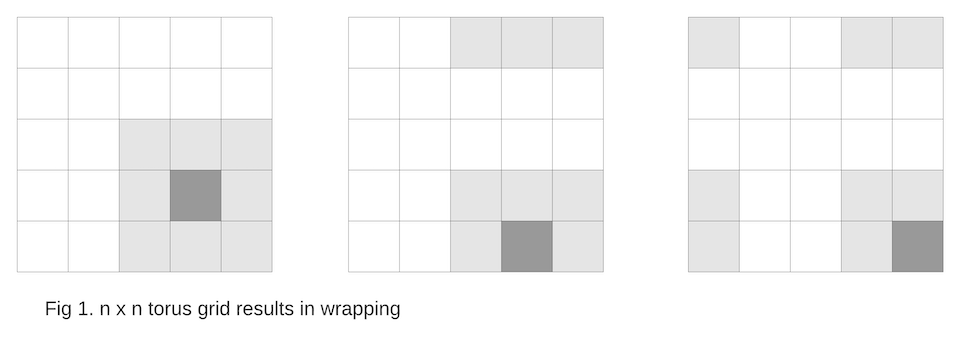

In [234]:
class AgentMover:
    
    # allowable moves
    directions = [[-1, 0], # left
                  [ 1, 0], # right
                  [ 0,-1], # up
                  [ 0, 1], # down
                  [-1,-1], # left & up
                  [-1, 1], # left & down
                  [ 1,-1], # right & up
                  [ 1, 1]] # right & down
    
    def __init__(self, n):
        self.n = n
        

    def get_random_position(self, selected):
        '''
        Returns a random (i,j) position in an n x n grid 
        which has not yet been selected.
        '''
        
        # try random position
        i = random.randint(0,self.n-1)
        j = random.randint(0,self.n-1)
        
        while (i,j) in selected:

            # keep trying if position has already been chosen
            i = random.randint(0,self.n-1)
            j = random.randint(0,self.n-1)
            
        return (i,j)
    
    
    def split_agents(self, agents):
        '''
        Splits agents into those which are distancing and other. 
        Returns tuple of two lists:(distancing agents, other agents)
        '''
        
        # position distancing agents first
        distancing_agents = list()
        other_agents = list()
        
        for agent in agents:
            if agent.distancing:
                distancing_agents.append(agent)
            else:
                other_agents.append(agent)
                
        return distancing_agents, other_agents
    
        
    def get_x(self, x_curr, change):
        '''
        Calculates next x coordinate, wrapping around torus 
        grid if position would move off the top or bottom.
        '''
        
        x_result = x_curr + change
        if x_result < 0:
            x_next = self.n-1
        elif x_result > self.n-1:
            x_next = 0
        else:
            x_next = x_result
                
        return x_next
 

    def get_y(self, y_curr, change):
        '''
        Calculates next y coordinate, wrapping around torus 
        grid if position would move off the left or right.
        '''        
        
        y_result = y_curr + change
        if y_result < 0:
            y_next = self.n-1
        elif y_result > self.n-1:
            y_next = 0
        else:
            y_next = y_result
                
        return y_next

    
    def get_adj_positions(self, position):
        '''
        Returns a list of all 8 positions which surround the given position, 
        wrapping around the torus grid when necessary.
        '''

        adjacent = set()
        
        x_curr = position[0]
        y_curr = position[1]
        
        for x_change,y_change in self.directions:
            
            # get resulting coordinates after change
            x_next = self.get_x(x_curr, x_change)
            y_next = self.get_y(y_curr, y_change)
        
            adjacent.add((x_next, y_next))
        
        return adjacent
    
    
    def positions_available(self, unavailable, agents, positioned):
        '''
        Returns True if there is at least one positions 
        available for each agent not yet positioned.
        '''
        
        num_agents_left = len(agents) - positioned
        num_positions_left = self.n * self.n - len(unavailable)
        return num_positions_left >= num_agents_left
    
    
    def position_distancing_agents(self, distancing_agents):
        '''
        Attempts to find unique positions for given list of distancing agents 
        such that every agent maintains at least one position between itself
        and every other agent. Returns (True, unavailable) if such a positioning 
        is found. Returns (False, unavailable) otherwise. unavailable is a
        set containing all positions which can not be selected for agents.
        '''
                   
        # reset for new attempt
        unavailable = set()
        num_positioned = 0

        for agent in distancing_agents: 
            
            # if there aren't enough available positions left, start over
            if not self.positions_available(unavailable, distancing_agents, num_positioned):
                return (False, unavailable)           
        
            # choose available position
            position = self.get_random_position(unavailable)
            agent.position = position

            # update available positions
            curr_unavailable = self.get_adj_positions(position) # positions surrounding are not available
            curr_unavailable.add(position)                      # position taken is not available
            unavailable = unavailable.union(curr_unavailable)   # update full list
        
            # update counter
            num_positioned += 1
        
        # all agents were positioned successfully
        return (True, unavailable)
    
    
    def position_remaining_agents(self, agents, unavailable):
        '''
        Positions all agents without distancing requirements.
        Returns True if agents were positioned successfully,
        False otherwise.
        '''
        
        num_positioned = 0
        for agent in agents:
            
            # if there aren't enough available positions left, start over
            if not self.positions_available(unavailable, agents, num_positioned):
                return False
        
            # choose available position
            position = self.get_random_position(unavailable)
            agent.position = position

            # update available positions                     
            unavailable.add(position)
        
            # update counter
            num_positioned += 1
        
        # all agents were positioned successfully
        return True
        

    def position_agents(self, agents):
        '''
        Positions given agents on n x n grid, following distancing constraints
        for distancing agents. Raises ValueError if no viable positioning
        is found. Returns True if positioning is found.
        '''
        
        # split agents into distancing and other
        distancing_agents, other_agents = self.split_agents(agents)
        
        # attempt to position distancing agents first
        attempt_counter = 0
        d_success = False
        unavailable = set()
        
        while d_success == False and attempt_counter < 100:
        
            d_success, unavailable = self.position_distancing_agents(distancing_agents)
            attempt_counter += 1
        
        if attempt_counter >= 100:
            raise ValueError('Unable to find positions for all distancing agents')
        
        
        # position remaining agents
        all_success = self.position_remaining_agents(other_agents, unavailable)
        if all_success == False:
            raise ValueError('Unable to find positions for remaining agents')
 
        # all agents positioned
        return True
            
            
    def get_unoccupied_positions(self, agent, agents, positions):
        pass
      
        
    def get_undistanced_positions(self, agent, agents, positions):
        
        # find all agents within
        
        # split agents into distancing and other
        distancing_agents, other_agents = self.split_agents(agents)
    
    
    def get_distancing_positions(self, agent, agents, positions):
        pass
    
    
    def find_nearby_agents(self, agent, agents, position):
        '''
        Finds all agents within 2 spaces of this agent in every direction.
        This reduces the search space for available positions to only
        those agents which may be affected by this agent after a move.
        '''
        pass
        
        
    
    
    def get_available_moves(self, agent, agents):
        '''
        Returns a list of possible positions to which a
        given agent can move, given the other agents.
        
        Constrained by the current position of other agents
        and whether another agent is distancing.
        '''
        pass
    
        # determine all positions 1 move away from agent
        
        
        # determine all agents within 2 positions from agent
        
        
        # determine which of those positions are:
        # 1 - not occupied
        # 2 - allow this agent to maintain its own distancing boundaries if necessary
        # 3 - outside distancing boundaries of another agent
        
        
        # 1 - check for occupation
        
        # 2 - check for this agent's distancing
        
        # 3 - check for distancing agents        
        
       
    def move_agent(self, agent, positions):
        '''
        Selects a random position from positions and 
        updates the agent to be at that location.
        
        If positions list is empty, does not move
        the agent.
        '''
        if positions:
            i = random.randint(0,len(positions)-1) # random index
            agent.position = positions[i]     
        
    
    
    def move_all_agents(self, agents):
        '''
        Selects and moves each agent in agents.
        '''
        for agent in agents:
            moves = self.get_available_moves(agent, agents)
            move_agent(agent, moves)

#### Test AgentMover class

In [218]:
print('Test get_random_position()')
n=25
am = AgentMover(n)

selected = list()
position = am.get_random_position(selected)

# check if position is within n x n grid
assert position[0] >= 0
assert position[0] < n
assert position[1] >= 0
assert position[1] < n

# check if position has been taken already
# create list with all positions taken except (0,0)
selected = [(i,j) for i in range(n) for j in range(n) if (i,j) != (0,0) ]
position = am.get_random_position(selected)
assert position == (0,0)

Test get_random_position()


In [219]:
print('Test split_agents()')
n=25
am = AgentMover(n)

a1 = Agent((1,2), 'I', mask=True, distancing=True)
a2 = Agent((1,2), 'I', mask=True, distancing=True)
a3 = Agent((1,2), 'R', mask=True, distancing=False)
a4 = Agent((1,2), 'R', mask=True, distancing=False)
a5 = Agent((1,2), 'R', mask=True, distancing=False)

distancing_agents, other_agents = am.split_agents([a1,a2,a3,a4,a5])

for agent in distancing_agents:
    assert agent.status == 'I'
    
for agent in other_agents:
    assert agent.status == 'R'
    
assert len(distancing_agents) == 2
assert len(other_agents) == 3

Test split_agents()


In [220]:
print('Test get_x()')

n=25
am = AgentMover(n)

assert am.get_x(0,-1) == n-1
assert am.get_x(0,1) == 1
assert am.get_x(n-1,1) == 0

Test get_x()


In [221]:
print('Test get_y()')

n=25
am = AgentMover(n)

assert am.get_y(0,-1) == n-1
assert am.get_y(0,1) == 1
assert am.get_y(n-1,1) == 0

Test get_y()


In [222]:
print('Test get_adj_positions()')

n=25
am = AgentMover(n)

# non-edge position
current_position = (1,1)
adjacent_correct = [(0,0),(0,1),(0,2),
                    (1,0),(1,2),
                    (2,0),(2,1),(2,2)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'


# lower right corner
current_position = (24,24)
adjacent_correct = [(23,0),(23,23),(23,24),
                    (24,0),(24,23),
                    (0,0),(0,23),(0,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# upper right corner
current_position = (0,24)
adjacent_correct = [(24,0),(24,23),(24,24),
                    (0,0),(0,23),
                    (1,0),(1,23),(1,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# lower left corner
current_position = (24,0)
adjacent_correct = [(23,0),(23,1),(23,24),
                    (24,1),(24,24),
                    (0,0),(0,1),(0,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# upper left corner
current_position = (0,0)
adjacent_correct = [(24,0),(24,1),(24,24),
                    (0,1),(0,24),
                    (1,0),(1,1),(1,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

Test get_adj_positions()
{(0, 1), (1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
{(0, 23), (23, 23), (24, 23), (0, 0), (23, 0), (24, 0), (0, 24), (23, 24)}
{(0, 23), (24, 23), (0, 0), (1, 24), (24, 0), (1, 23), (1, 0), (24, 24)}
{(0, 1), (23, 1), (24, 1), (0, 0), (23, 0), (0, 24), (23, 24), (24, 24)}
{(0, 1), (24, 1), (1, 24), (1, 1), (24, 0), (1, 0), (0, 24), (24, 24)}


In [223]:
print('Test positions_available()')

n=1
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
unavailable = set()

# (unavailable, agents, positioned)
assert am.positions_available(unavailable,[a1],0) == True 

unavailable.add(1)
assert am.positions_available(unavailable,[a1],0) == False


Test positions_available()


In [224]:
print('Test position_distancing_agents()')

# only possible to place one agent
n=3
am = AgentMover(n)
agents = [Agent((-1,-1), 'I', mask=True, distancing=True) for i in range(2)]
result, unavailable = am.position_distancing_agents(agents)
assert result == False


# multiple agents can be placed
n=25
am = AgentMover(n)
agents = [Agent((-1,-1), 'I', mask=True, distancing=True) for i in range(2)]
result, unavailable = am.position_distancing_agents(agents)
assert result == True


Test position_distancing_agents()


In [225]:
print('Test position_remaining_agents()')

n=1
am = AgentMover(n)

a1 = Agent((-1,-1), 'I', mask=True, distancing=False)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)

unavailable = set()

assert am.position_remaining_agents([a1],unavailable) == True


unavailable.add((0,0))
assert am.position_remaining_agents([a1],unavailable) == False

Test position_remaining_agents()


In [226]:
print('Test position_agents()')

# success
n=25
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)
agents = [a1,a2]

assert am.position_agents(agents) == True
for each in agents:
    print(each)
    
# failure
n=1
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)
agents = [a1,a2]

try:
    am.position_agents(agents)
    assert False
except ValueError:
    assert True

Test position_agents()
Agent{position:(11, 18), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:True}
Agent{position:(8, 14), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}


In [279]:
print('Test position_agents()')
m = 100
ag = AgentGenerator(m,1,0.25,0.35,0.45)
am = AgentMover(25)

agents = ag.generate_agents()
am.position_agents(agents)

positions = list()
for agent in agents:
    
    # all agents have been positioned
    assert agent.position != (-1,-1)
    positions.append(agent.position)
    
# ensure all positions are unique
assert len(set(positions)) == m 

Test position_agents()


#### Define ABM class

In [194]:
class ABM:


    status_colors = {'R': 'r', 'S': 'b', 'I': 'g', 'Q': 'k', 'D': 'm'}

    def __init__(self, n, m, num_infected, percent_distancing, percent_mask, percent_vaccinated = 0.0):
        self.n = n
        self.m = m
        
        # validate
        if m > n*n: 
            raise ValueError('n x n grid cannot hold all agents')
        
        # generate agents
        ag = AgentGenerator(m, num_infected, percent_distancing, percent_mask, percent_vaccinated)
        self.agents = ag.generate_agents()
        
        # position agents
        am = AgentMover(n)
        am.position_agents(self.agents)
        
        # set baseline metrics
        self.num_recovered = 0
        self.num_infected = 0
        self.num_susceptible = 0 
        self.num_dead = 0       
        self.num_quarantine = 0
        self.count_baseline_metrics()
        

      
    
    def count_baseline_metrics(self):
        for agent in agents:
            if agent.status == 'I':
                self.num_infected += 1
            elif agent.status == 'S':
                self.num_susceptible += 1
            elif agent.status == 'R':
                self.num_recovered += 1
                
#?? move all agents first, then update status, or do it one by one
#update status based on conditions. 

#     def remove_agent(self,agent):
#         '''
#         Remove agent from simulation if agent has died.
#         '''     



#     def add_counts(self):
#         counts = {'R': self.num_recovered, 'D': self.num_dead, 'I': self.num_infected, 'S': self.num_susceptible, 'Q': self.num_quarantine}
#         self.counts.append(counts)

        
#     def run_simulation(self, num_steps):
#         for t in range(num_steps):
#             for agent in self.agents:
#                 self.move_agent(agent)

#                 self.add_counts()

#         return self.counts


#     def run_and_visualize_simulation(self, num_steps):
#         """
#         Helper function for de-bugging. 

#         """

#         fig = plt.figure()
#         ax = fig.add_subplot(1,1,1)

#         for t in range(num_steps):
#             ax.cla()

#         for agent in self.agents:
#             self.move_agent(agent)
#             c = self.status_colors[agent.status]
#             m = 'o' if agent.distancing else 's'

#             ax.scatter(agent.position[0], agent.position[1], c=c, marker=m)

#         ax.grid(True)
#         ax.set_xticks(list(range(self.n)))
#         ax.set_yticks(list(range(self.n)))  

#         display(fig)
#         clear_output(wait=True)

#         plt.pause(5)
        
        

#### Test ABM class

In [ ]:
#  def runAndPlotSimulations(num_simulations, num_steps, world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated):
#     sim_counts = []
#     for i in range(num_simulations):
#       model = ABM(world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated)
#       counts = model.runSimulation(num_steps)
#       sim_counts.append(counts)


#     statusColors = {'R': 'r', 'S': 'b', 'I': 'g', 'Q': 'k', 'D': 'm'}
#     fig, ax = plt.subplots(figsize=(20, 10))
#     x = list(range(num_steps))

#     for status in ['R', 'S', 'I', 'Q', 'D']:
#       avgs = []
#       errs = []
#       for j in range(num_steps):
#         stats = np.array([counts[j][status] for counts in sim_counts])
#         avgs.append(np.mean(stats))
#         errs.append(np.std(stats))

#       ax.errorbar(x,avgs,yerr=errs, fmt=statusColors[status], label=status)

#     ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
#     plt.show()

## 1.2 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 

* 5 infected agents (I), the rest are susceptible (S)
* 0% of agents wear masks
* 0% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 


In [ ]:
# runAndPlotSimulations(10, 365, 25, 250, num_infected, percent_distancing, percent_mask, percent_vaccinated)

## 1.3 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), the rest are susceptible (S)
*   p% of agents wear masks
*   p% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What value of p reduces the final value of R to roughly half of the final value of R you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

In [ ]:
# runAndPlotSimulations(10, 365, 25, 250, num_infected, percent_distancing, percent_mask, percent_vaccinated)

## 1.4 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), p% of agents have been vaccinated (i.e., start in state R), the rest are susceptible (S)
*   0% of agents wear masks
*   0% of agents practice physical distancing


Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard errors. 
What value of p reduces the peak number of active cases (I+Q) to roughly half of the final value of (I+Q) you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

In [ ]:
# runAndPlotSimulations(10, 365, 25, 250, num_infected, percent_distancing, percent_mask, percent_vaccinated)